# Generative modelling in deep learning

MVA 2021-2022

Elías Masquil

Nicolás Violante

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> Kullback-Leibler divergence or its symmetrized version, the Jensen-Shannon divergence. Another options is the Wasserstein distance.

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> On the one hand, comparing values sampled from distributions is usually easier than comparing densities. Specially in most of the examples concerned for this problem, in which we assume that is easy to sample from the distributions. However estimates obtained from samples (e.g Montecarlo) are known to have high variance and thus, two estimates of the same quantity can greatly differ. In the case of comparing density distributions, we don't get estimates with high variance, but rather exact solutions. The downside is that unless we're considering distributions with a tractable closed form, we cannot compare the distributions analytically. Moreover, depending on the metric (e.g Optimal Transport) can be very hard to compute the distance, despite having distributions with closed form.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> A bigger dimension $N$ should lead to a more expresive model.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> JSD has many caveats: 
* Vanishing gradients as this loss gets saturated near the optimal value. This is mostly problematic on early stages of training. If the discriminator is too good (compared to the generator), then there's no valuable feedback for the generator. 
* JSD is not continuous, we can have a sequence of weights converging to the optimal value while JSD doesn't converge to 0

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> This can cause mode collapse. Since the generator only gets feedback from the samples it has generated, this can lead to generating very plausible images that are not representative of the whole distribution. E.g we train the model on a dataset of dogs, cats, and wolves, but the generator only keeps getting better at generating dogs and ends up generating only dogs (the loss would encourage the model to do this, and there's no incentive in generating the rest of the categories).

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [ ]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

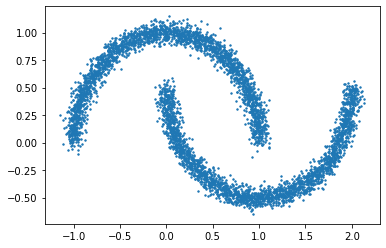

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)
        
    def __call__(self, z):
        return self.fc1(z)
    
    # Add device to the Generator
    def generate(self, batchlen, device=torch.device("cpu")):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0).to(device)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
    
    def __call__(self, x):
        return self.fc1(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
discriminator = Discriminator()

# moving models to gpu
generator = generator.to(device)
discriminator = discriminator.to(device)

def train_gans(generator, discriminator):
    optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))
    for i in range(N_ITER):
        # train the discriminator
        for _ in range(TRAIN_RATIO):
            discriminator.zero_grad()
            real_batch = generate_batch(BATCHLEN).to(device)
            fake_batch = generator.generate(BATCHLEN, device)
            # ----------------------------------------------------------------------
            real_logits = discriminator(real_batch)
            fake_logits = discriminator(fake_batch) 
            real_probs = torch.sigmoid(real_logits)
            fake_probs = torch.sigmoid(fake_logits)
            disc_loss = torch.mean(-torch.log(real_probs)) + torch.mean(-torch.log(1 - fake_probs)) 
            # ----------------------------------------------------------------------
            disc_loss.backward()
            optim_disc.step()
            
        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(BATCHLEN, device)
        # --------------------------------------------------------------------------
        fake_logits = discriminator(fake_batch)
        fake_probs = torch.sigmoid(fake_logits)
        gen_loss = - torch.mean(torch.log(fake_probs))
        # --------------------------------------------------------------------------
        gen_loss.backward()
        optim_gen.step()
        if i%1000 == 0:
            disc_loss = disc_loss.detach().cpu()
            gen_loss = gen_loss.detach().cpu()
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
            # plot the result
            real_batch = generate_batch(1024)
            fake_batch = generator.generate(1024, device).detach().cpu()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.legend()
            plt.show()

step 0: discriminator: 1.159e+00, generator: 8.279e-01


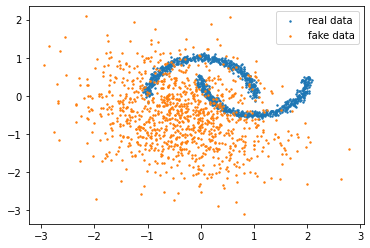

step 1000: discriminator: 1.526e+00, generator: 6.409e-01


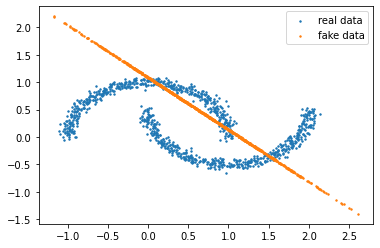

step 2000: discriminator: 1.276e+00, generator: 7.934e-01


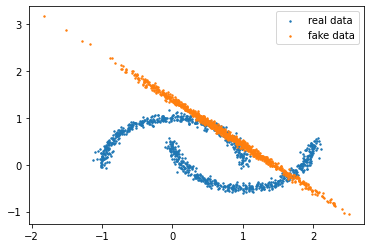

step 3000: discriminator: 1.389e+00, generator: 7.028e-01


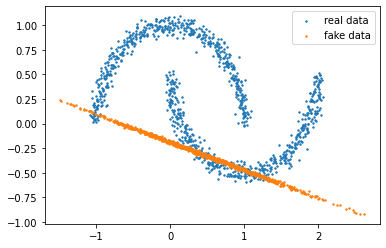

step 4000: discriminator: 1.377e+00, generator: 6.975e-01


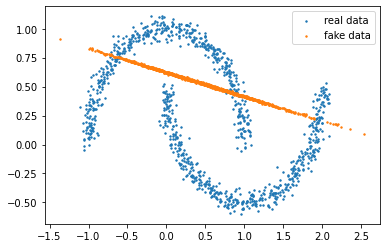

step 5000: discriminator: 1.387e+00, generator: 6.930e-01


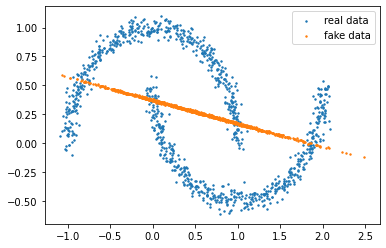

step 6000: discriminator: 1.386e+00, generator: 6.930e-01


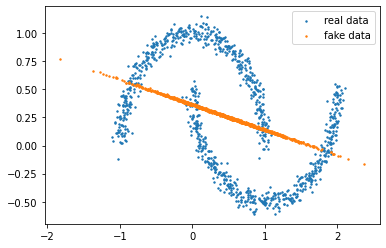

step 7000: discriminator: 1.386e+00, generator: 6.933e-01


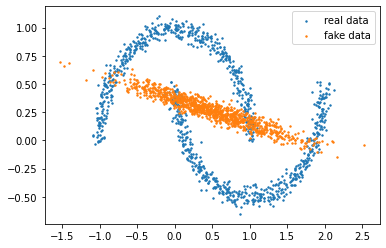

step 8000: discriminator: 1.386e+00, generator: 6.932e-01


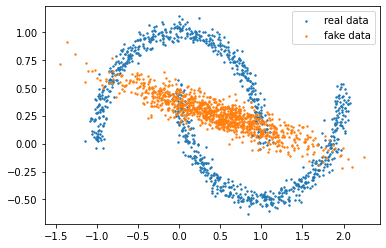

step 9000: discriminator: 1.386e+00, generator: 6.931e-01


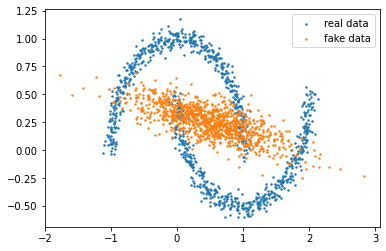

step 10000: discriminator: 1.386e+00, generator: 6.931e-01


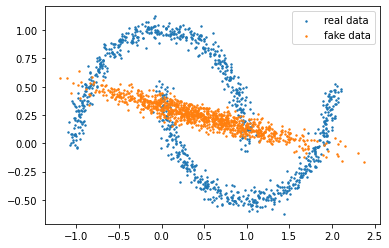

step 11000: discriminator: 1.386e+00, generator: 6.934e-01


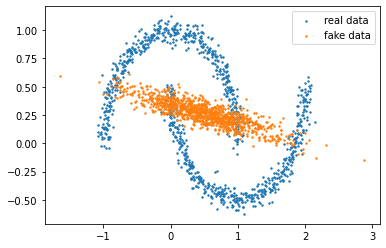

step 12000: discriminator: 1.386e+00, generator: 6.931e-01


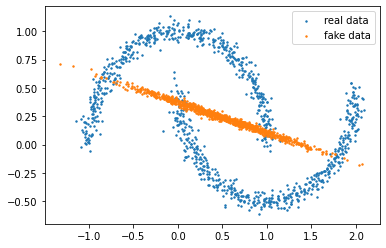

step 13000: discriminator: 1.386e+00, generator: 6.931e-01


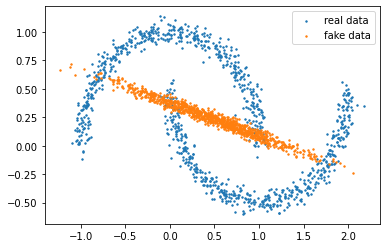

step 14000: discriminator: 1.386e+00, generator: 6.931e-01


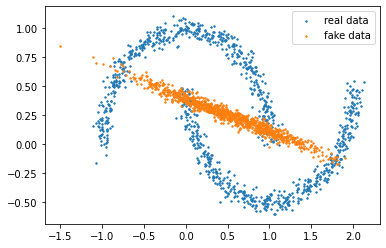

step 15000: discriminator: 1.386e+00, generator: 6.934e-01


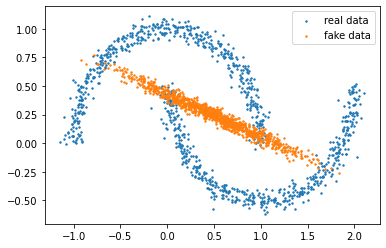

step 16000: discriminator: 1.386e+00, generator: 6.934e-01


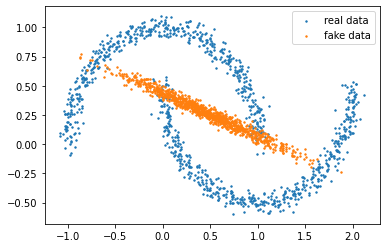

step 17000: discriminator: 1.386e+00, generator: 6.932e-01


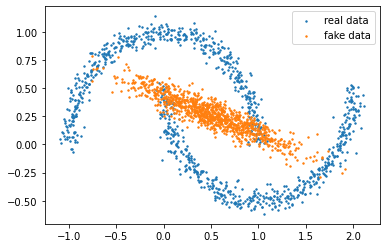

step 18000: discriminator: 1.386e+00, generator: 6.931e-01


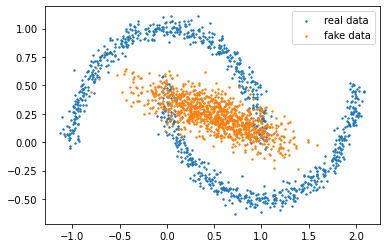

step 19000: discriminator: 1.386e+00, generator: 6.928e-01


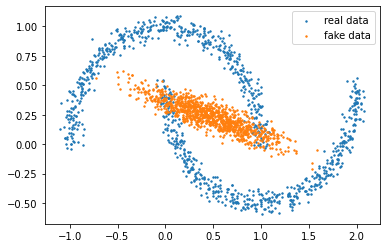

step 20000: discriminator: 1.386e+00, generator: 6.933e-01


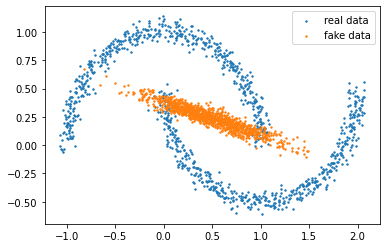

In [ ]:
train_gans(generator, discriminator)

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> As explained before, at early stages of training specially, if the discriminator is too good, this leads to vanishing gradients in the generator loss. In this case $\log(1-D(x))$ saturates, the generator doesn't get any feedback and its prevented from learning.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

In [ ]:
# Define the generator
class CustomGenerator(nn.Module):
    def __init__(self, depth, width):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, width)
        self.hidden_layers = nn.ModuleList()
        for i in range(depth-1):
            self.hidden_layers.append(nn.Linear(width, width))
        self.output_layer = nn.Linear(width, 2)
        

    def __call__(self, z):
        z = self.fc1(z)
        z = F.leaky_relu(z)
        for layer in self.hidden_layers:
            z = layer(z)
            z = F.leaky_relu(z)
        return self.output_layer(z)


    # Add device to the Generator
    def generate(self, batchlen, device=torch.device("cpu")):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0).to(device)
        return self.__call__(z)
    

# Define the discriminator
class CustomDiscriminator(nn.Module):
    def __init__(self, depth, width):
        super().__init__()
        self.fc1 = nn.Linear(2, width)
        self.hidden_layers = nn.ModuleList()
        for i in range(depth-1):
            self.hidden_layers.append(nn.Linear(width, width))
        self.output_layer = nn.Linear(width, 1)
    
    def __call__(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = F.relu(x)
        return self.output_layer(x)

**More expressive models are able to generate the dataset**

In [ ]:
generator = CustomGenerator(5, 20).to(device)
discriminator = CustomDiscriminator(5, 20).to(device)

step 0: discriminator: 1.391e+00, generator: 7.663e-01


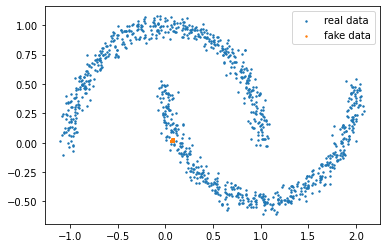

step 1000: discriminator: 1.179e+00, generator: 9.873e-01


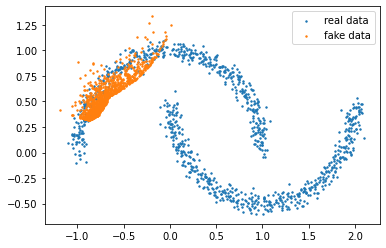

step 2000: discriminator: 1.385e+00, generator: 6.971e-01


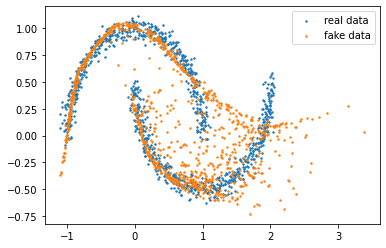

step 3000: discriminator: 1.384e+00, generator: 7.516e-01


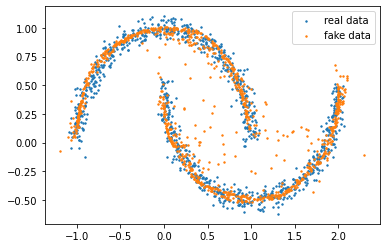

step 4000: discriminator: 1.385e+00, generator: 6.953e-01


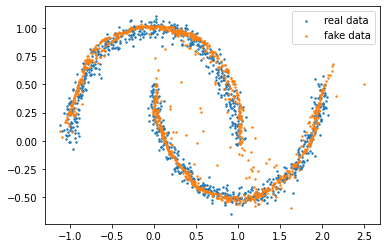

step 5000: discriminator: 1.383e+00, generator: 6.727e-01


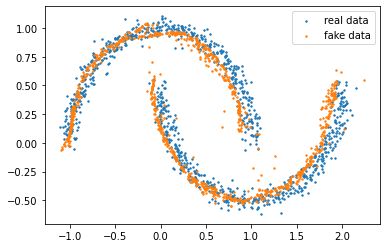

step 6000: discriminator: 1.384e+00, generator: 6.906e-01


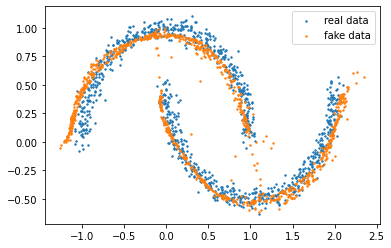

step 7000: discriminator: 1.386e+00, generator: 6.982e-01


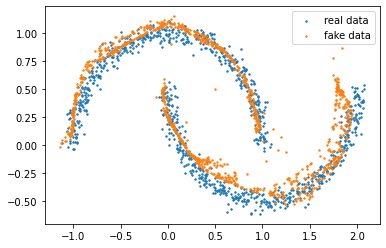

step 8000: discriminator: 1.387e+00, generator: 6.971e-01


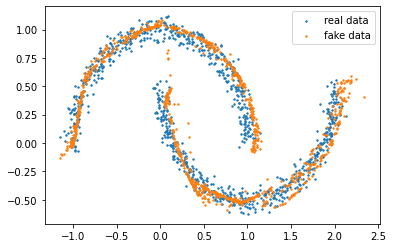

step 9000: discriminator: 1.387e+00, generator: 6.992e-01


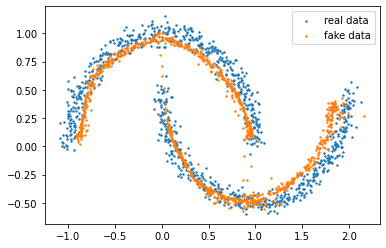

step 10000: discriminator: 1.388e+00, generator: 6.997e-01


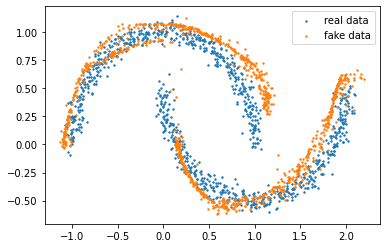

step 11000: discriminator: 1.389e+00, generator: 6.907e-01


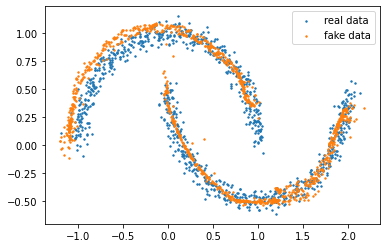

step 12000: discriminator: 1.387e+00, generator: 6.940e-01


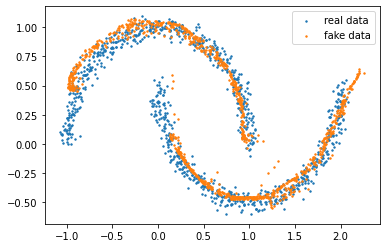

step 13000: discriminator: 1.353e+00, generator: 7.437e-01


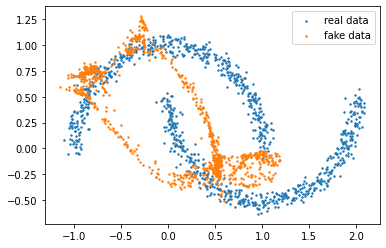

step 14000: discriminator: 1.389e+00, generator: 7.024e-01


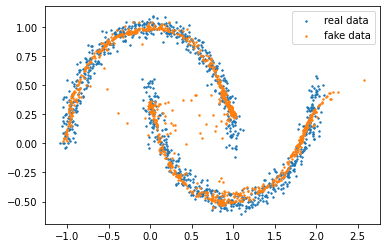

step 15000: discriminator: 1.389e+00, generator: 6.910e-01


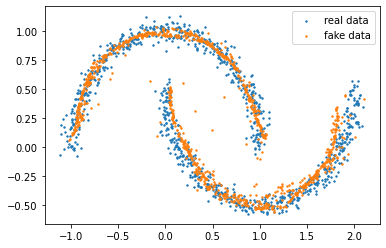

step 16000: discriminator: 1.378e+00, generator: 6.918e-01


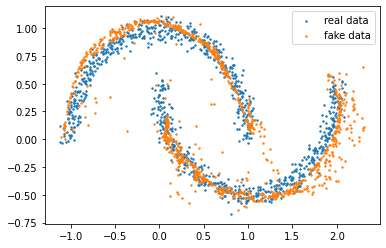

step 17000: discriminator: 1.381e+00, generator: 6.978e-01


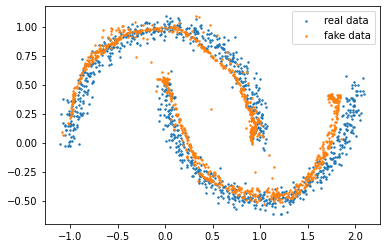

step 18000: discriminator: 1.374e+00, generator: 7.237e-01


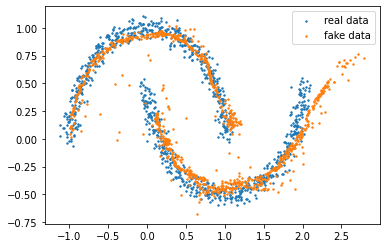

step 19000: discriminator: 1.385e+00, generator: 6.978e-01


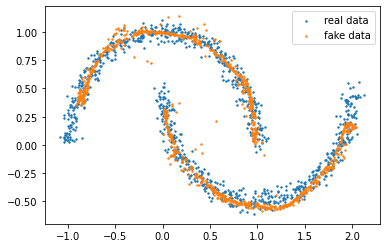

step 20000: discriminator: 1.391e+00, generator: 7.128e-01


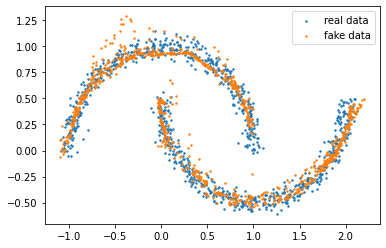

In [ ]:
train_gans(generator, discriminator)

**Small generator, big discriminator**

step 0: discriminator: 1.389e+00, generator: 6.552e-01


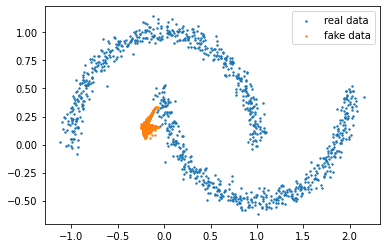

step 1000: discriminator: 1.132e+00, generator: 1.006e+00


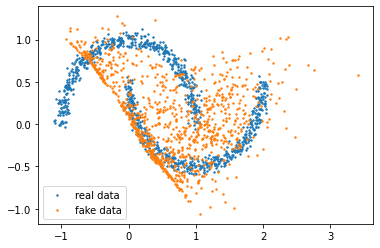

step 2000: discriminator: 9.552e-01, generator: 1.265e+00


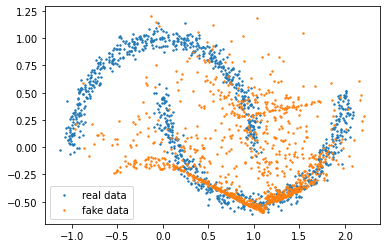

step 3000: discriminator: 9.394e-01, generator: 1.507e+00


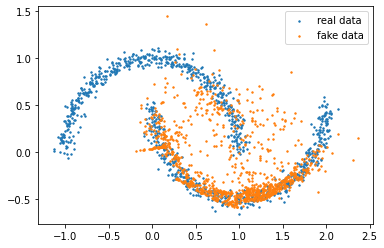

step 4000: discriminator: nan, generator: nan


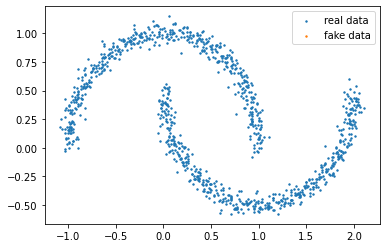

step 5000: discriminator: nan, generator: nan


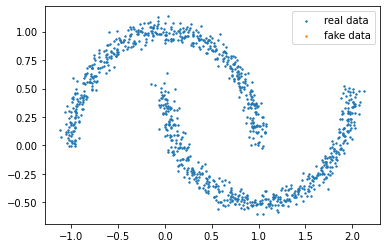

step 6000: discriminator: nan, generator: nan


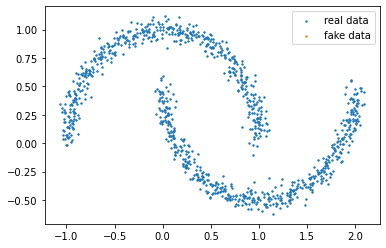

step 7000: discriminator: nan, generator: nan


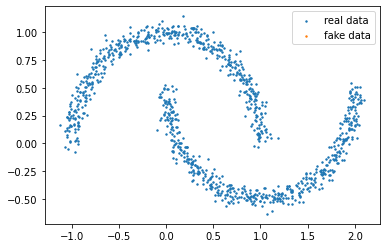

step 8000: discriminator: nan, generator: nan


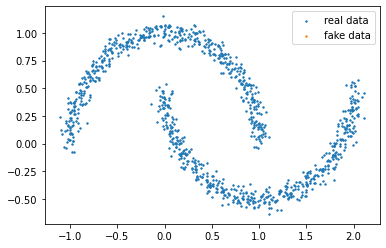

step 9000: discriminator: nan, generator: nan


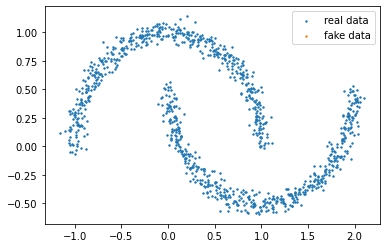

step 10000: discriminator: nan, generator: nan


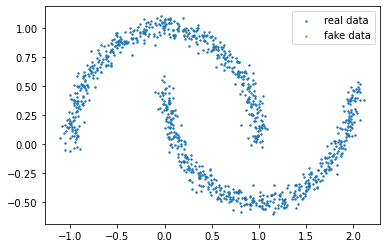

step 11000: discriminator: nan, generator: nan


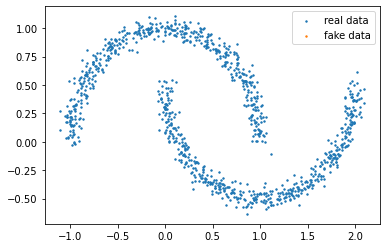

step 12000: discriminator: nan, generator: nan


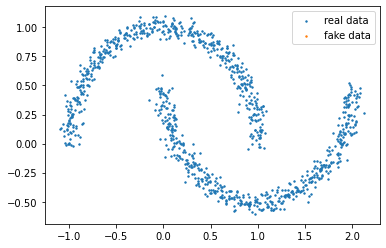

step 13000: discriminator: nan, generator: nan


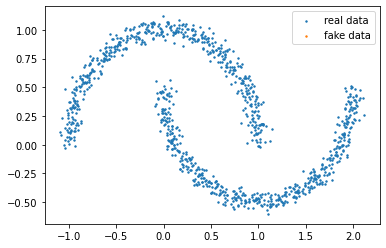

step 14000: discriminator: nan, generator: nan


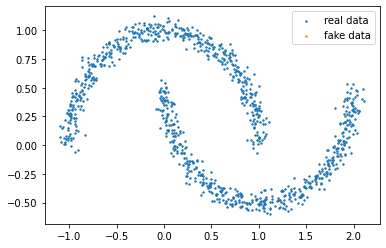

step 15000: discriminator: nan, generator: nan


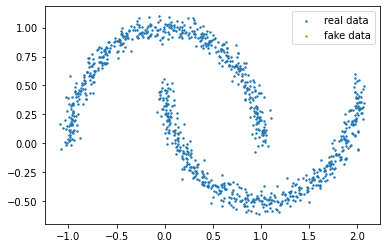

step 16000: discriminator: nan, generator: nan


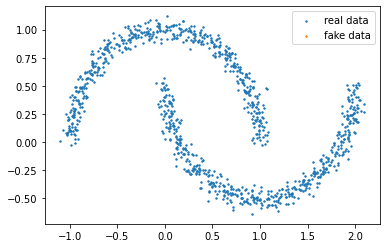

step 17000: discriminator: nan, generator: nan


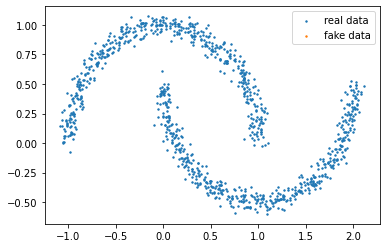

step 18000: discriminator: nan, generator: nan


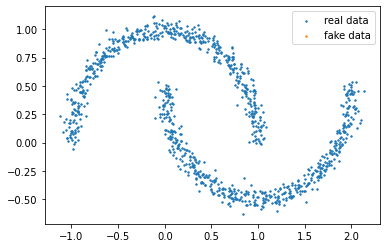

step 19000: discriminator: nan, generator: nan


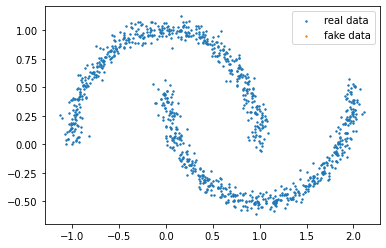

step 20000: discriminator: nan, generator: nan


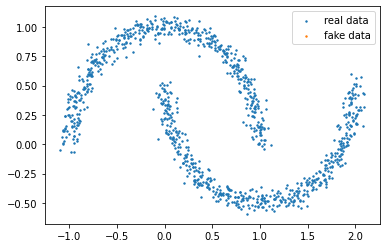

In [ ]:
generator = CustomGenerator(2, 5).to(device)
discriminator = CustomDiscriminator(5, 20).to(device)
train_gans(generator, discriminator)

**Small discriminator, big generator**

step 0: discriminator: 1.406e+00, generator: 8.345e-01


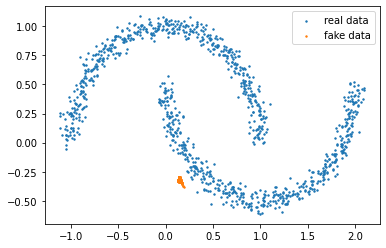

step 1000: discriminator: 1.419e+00, generator: 6.833e-01


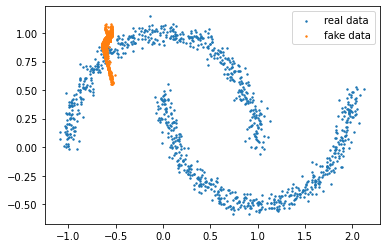

step 2000: discriminator: 1.408e+00, generator: 6.757e-01


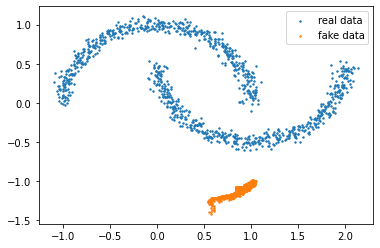

step 3000: discriminator: 1.389e+00, generator: 6.921e-01


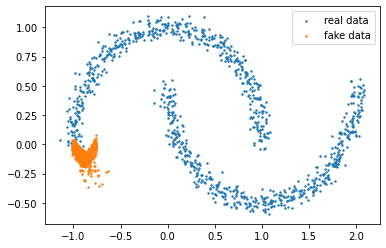

step 4000: discriminator: 1.384e+00, generator: 6.945e-01


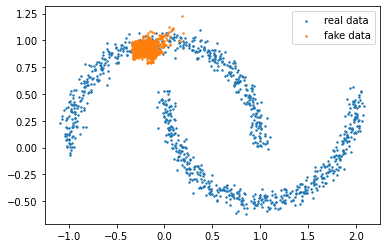

step 5000: discriminator: 1.395e+00, generator: 6.902e-01


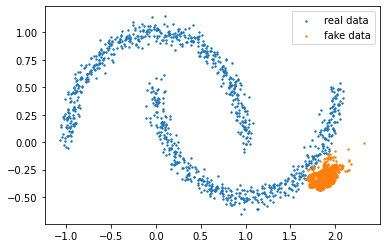

step 6000: discriminator: 1.386e+00, generator: 6.934e-01


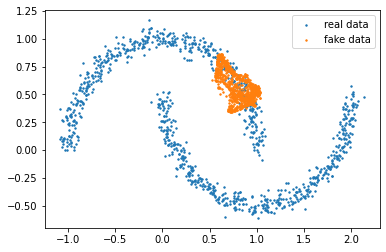

step 7000: discriminator: 1.387e+00, generator: 6.948e-01


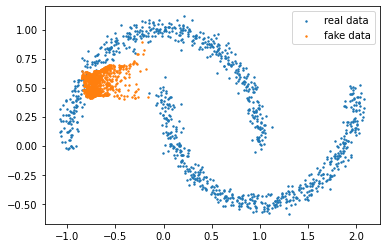

step 8000: discriminator: 1.396e+00, generator: 6.935e-01


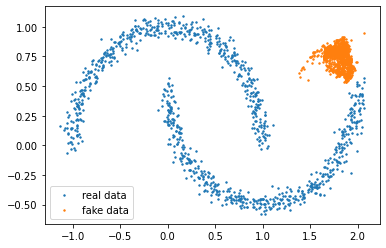

step 9000: discriminator: 1.395e+00, generator: 6.899e-01


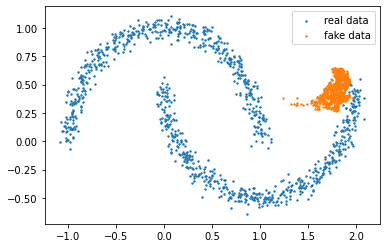

step 10000: discriminator: 1.392e+00, generator: 6.921e-01


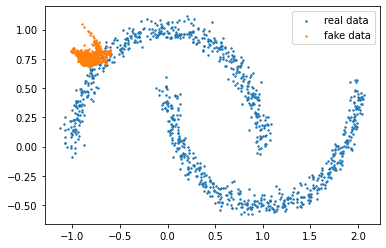

step 11000: discriminator: 1.380e+00, generator: 6.960e-01


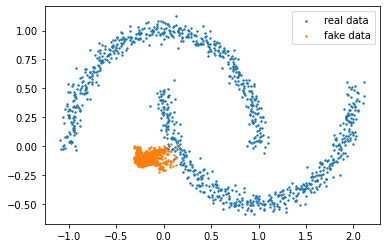

step 12000: discriminator: 1.391e+00, generator: 6.908e-01


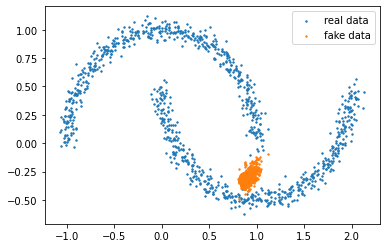

step 13000: discriminator: 1.397e+00, generator: 6.898e-01


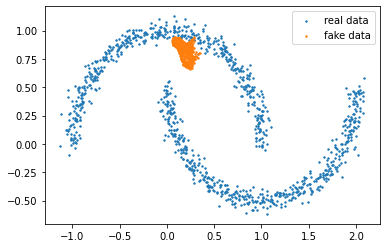

step 14000: discriminator: 1.391e+00, generator: 6.901e-01


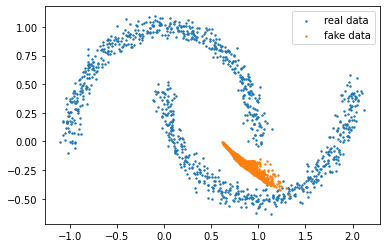

step 15000: discriminator: 1.387e+00, generator: 6.919e-01


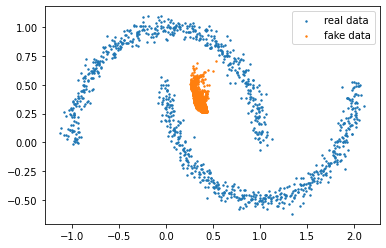

step 16000: discriminator: 1.392e+00, generator: 6.897e-01


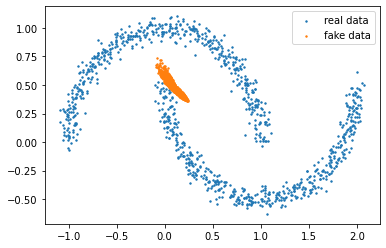

step 17000: discriminator: 1.386e+00, generator: 6.968e-01


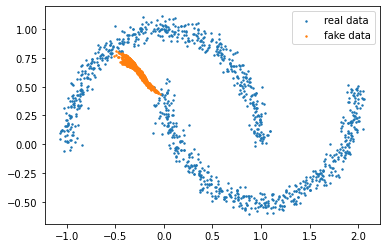

step 18000: discriminator: 1.388e+00, generator: 6.972e-01


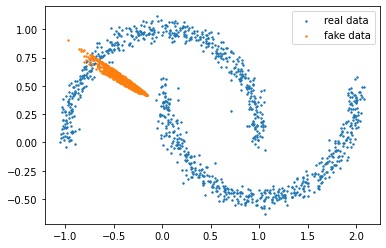

step 19000: discriminator: 1.386e+00, generator: 6.986e-01


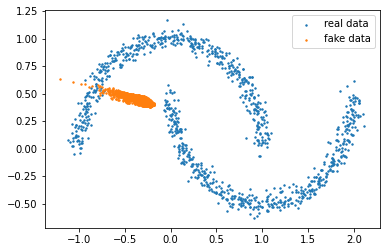

step 20000: discriminator: 1.386e+00, generator: 6.921e-01


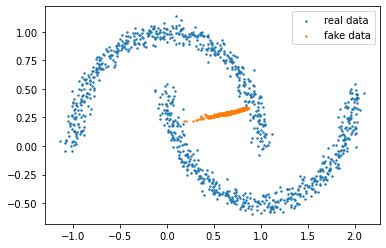

In [ ]:
generator = CustomGenerator(5, 20).to(device)
discriminator = CustomDiscriminator(2, 5).to(device)
train_gans(generator, discriminator)

**Different TRAIN_RATIO**

step 0: discriminator: 1.395e+00, generator: 6.046e-01


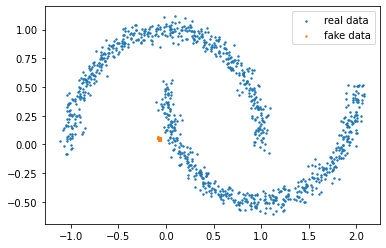

step 1000: discriminator: 1.290e+00, generator: 7.850e-01


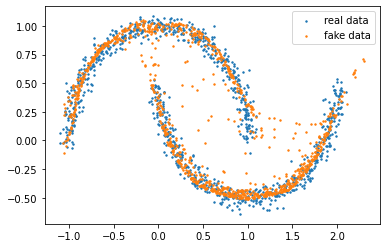

step 2000: discriminator: 1.373e+00, generator: 6.826e-01


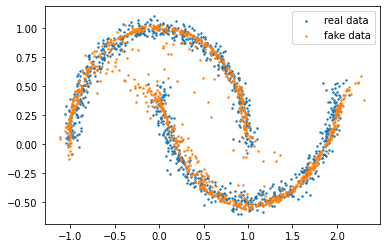

step 3000: discriminator: 1.387e+00, generator: 7.021e-01


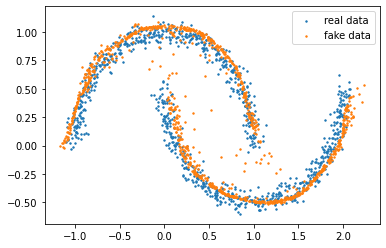

step 4000: discriminator: 1.384e+00, generator: 7.099e-01


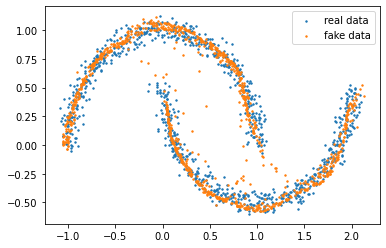

step 5000: discriminator: 1.379e+00, generator: 6.683e-01


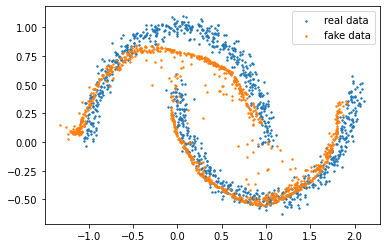

step 6000: discriminator: 1.334e+00, generator: 7.640e-01


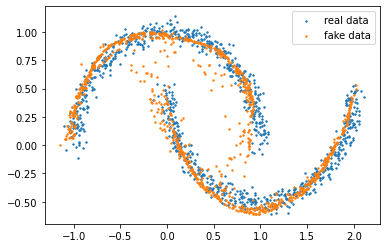

step 7000: discriminator: 1.369e+00, generator: 7.017e-01


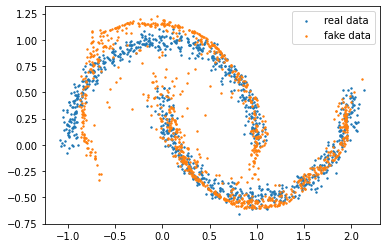

step 8000: discriminator: 1.391e+00, generator: 7.271e-01


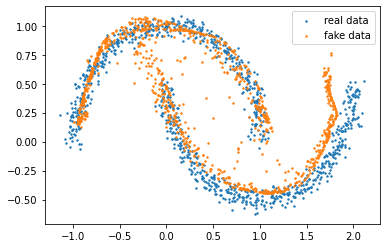

step 9000: discriminator: 1.386e+00, generator: 6.961e-01


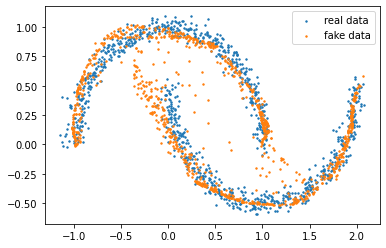

step 10000: discriminator: 1.382e+00, generator: 6.991e-01


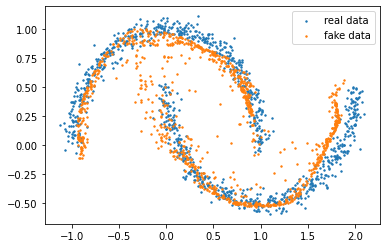

step 11000: discriminator: 1.372e+00, generator: 7.052e-01


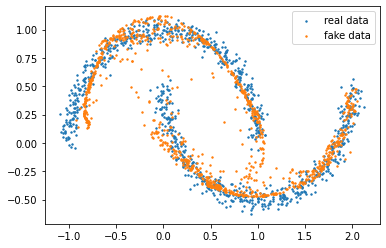

step 12000: discriminator: 1.388e+00, generator: 7.003e-01


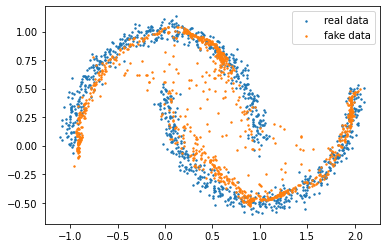

step 13000: discriminator: 1.384e+00, generator: 6.896e-01


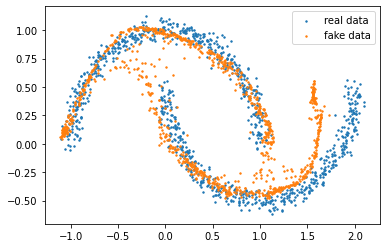

step 14000: discriminator: 1.390e+00, generator: 7.134e-01


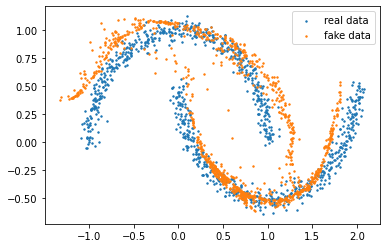

step 15000: discriminator: 1.387e+00, generator: 7.008e-01


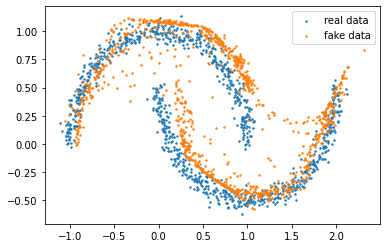

step 16000: discriminator: 1.396e+00, generator: 6.965e-01


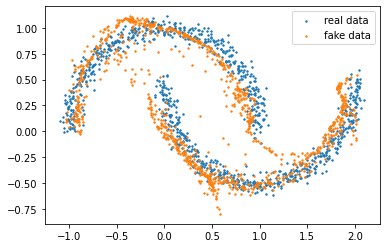

step 17000: discriminator: 1.386e+00, generator: 6.924e-01


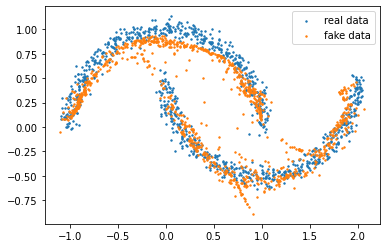

step 18000: discriminator: 1.386e+00, generator: 6.975e-01


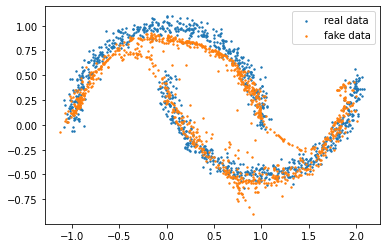

step 19000: discriminator: 1.386e+00, generator: 6.932e-01


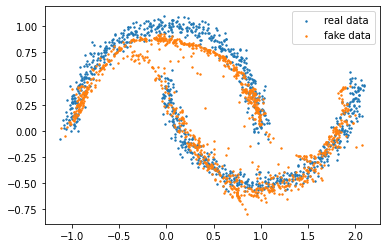

step 20000: discriminator: 1.386e+00, generator: 6.944e-01


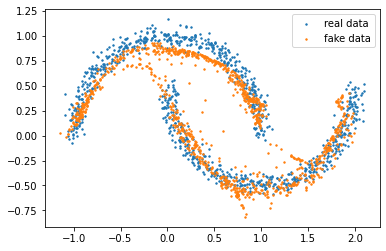

In [ ]:
generator = CustomGenerator(5, 20).to(device)
discriminator = CustomDiscriminator(5, 20).to(device)
TRAIN_RATIO = 5
train_gans(generator, discriminator)

step 0: discriminator: 1.389e+00, generator: 7.597e-01


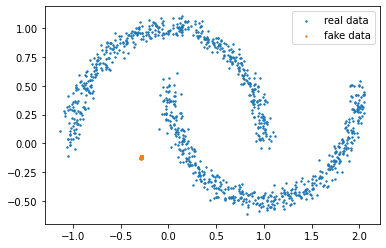

step 1000: discriminator: nan, generator: nan


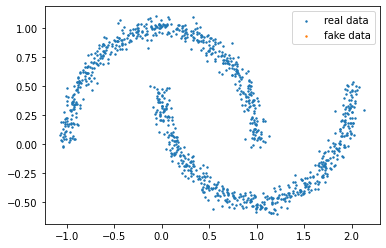

step 2000: discriminator: nan, generator: nan


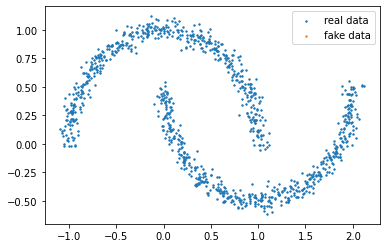

step 3000: discriminator: nan, generator: nan


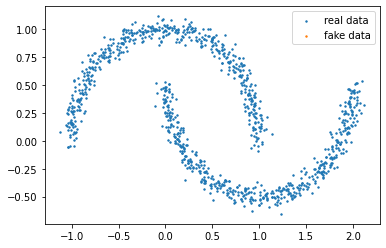

step 4000: discriminator: nan, generator: nan


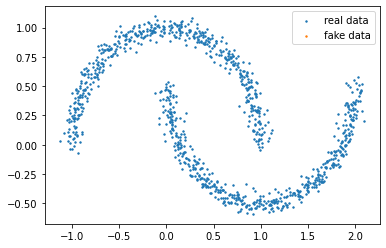

step 5000: discriminator: nan, generator: nan


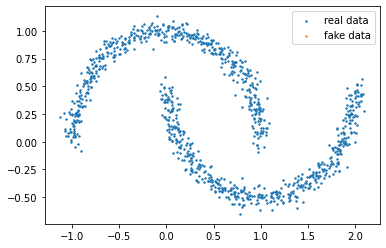

step 6000: discriminator: nan, generator: nan


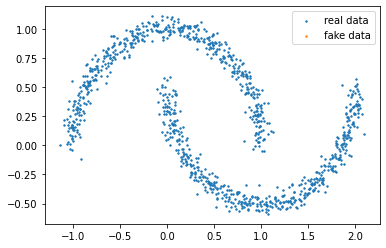

step 7000: discriminator: nan, generator: nan


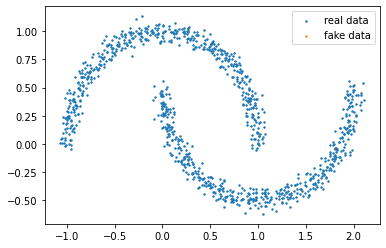

step 8000: discriminator: nan, generator: nan


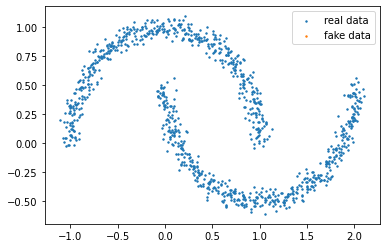

step 9000: discriminator: nan, generator: nan


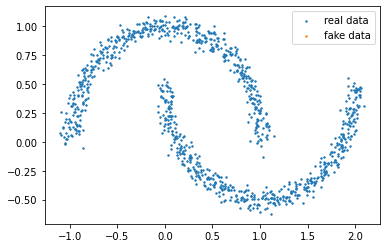

step 10000: discriminator: nan, generator: nan


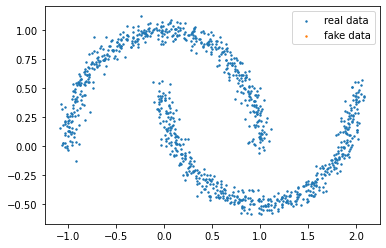

step 11000: discriminator: nan, generator: nan


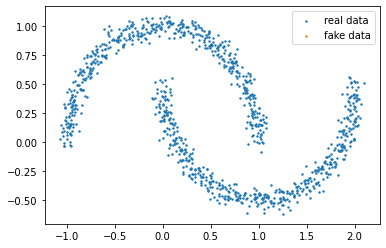

step 12000: discriminator: nan, generator: nan


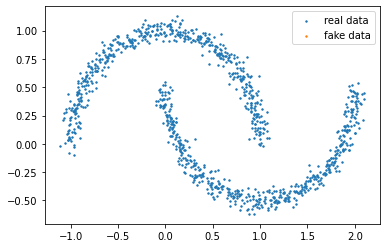

step 13000: discriminator: nan, generator: nan


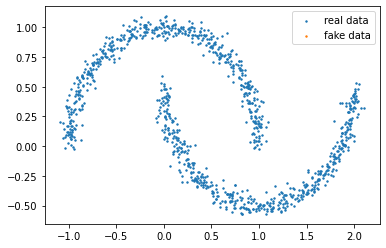

step 14000: discriminator: nan, generator: nan


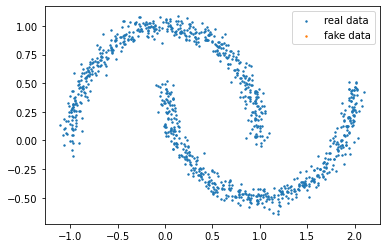

step 15000: discriminator: nan, generator: nan


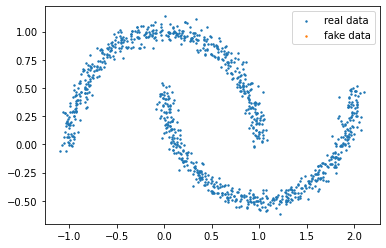

step 16000: discriminator: nan, generator: nan


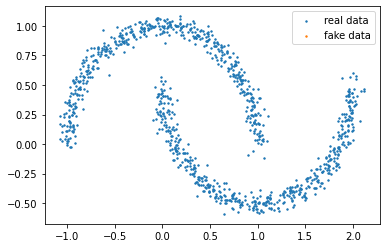

step 17000: discriminator: nan, generator: nan


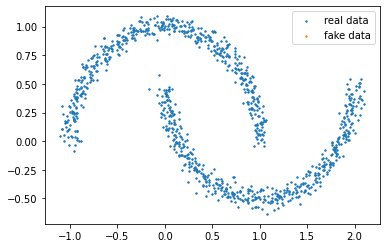

step 18000: discriminator: nan, generator: nan


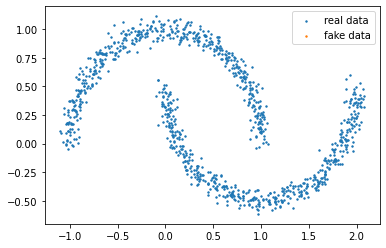

step 19000: discriminator: nan, generator: nan


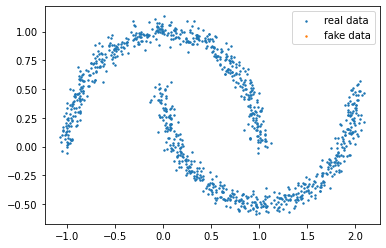

step 20000: discriminator: nan, generator: nan


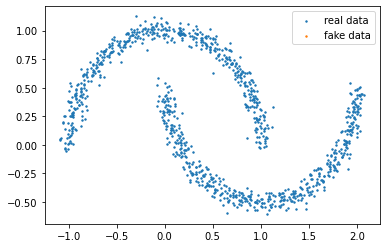

In [ ]:
generator = CustomGenerator(5, 20).to(device)
discriminator = CustomDiscriminator(5, 20).to(device)
TRAIN_RATIO = 10
train_gans(generator, discriminator)

> The original models weren't expressive enough to fit this dataset. By increasing both the width and depth of the generator and the discriminator, we've been able to learn an acceptable generative model for this dataset. 
>
>If the generator is not big enough, but the discriminator is big, training gets unstable and we cannot learn the dataset. The generator needs to be expressive enough to fool the discriminator. Training a small discriminator with a big generator doesn't work either, having a too-simple discriminator who's not able to catch the generator, results in a kind of mode collapse; the generator doesn't need to improve in order to beat the discriminator.
>
>Increasing the `TRAIN_RATIO`, makes the discriminator train for more iterations than the generator. Increasing its value x5 results in the same final results, but it seems that the dataset was fit earlier during training. Increasing too much this value (x10), causes the discriminator to overfit the generated data, which prevents the training of the generator because of vanishing gradients (JSD saturates).

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> $D_{KL}(p_D||p_\theta) = \int p_D(x) log(\frac{p_D(x)}{p_\theta(x)})dx = \mathbb{E}_{p_D}[logp_D(x)] - \mathbb{E}_{p_D}[logp_\theta(x)]$
>
> Then, taking the $\text{arg} \min_\theta D_{KL}(p_D||p_\theta)$ is equivalent to taking the $\text{arg} \max_\theta \mathbb{E}_{p_D}[logp_\theta(x)]$

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> This can impact data generation once the model is trained. As we didn't sample $p(z)$ during training, maybe when sampling from $p(z)$ and generating an output with the decoder over that sample, the output is not similar as the ones from the training set. If the distribution generated by the encoder didn't end up being close to the prior $p(z)$, then the decoder might fail when generating samples directly from this prior.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> We have the KL between two multivariate Gaussians, using the following [formula](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Kullback%E2%80%93Leibler_divergence) with $k$ being the dimension of the latent space
>
> $D_{KL}(q_\phi(z|x)||p(z)) = \frac{1}{2} \bigg(tr(Diag(\sigma^2_\phi(x)))  + \mu_\phi(x)^T\mu_\phi(x) - k - log \text{ det}(Diag(\sigma^2_\phi(x)) \bigg)$
>
>$D_{KL}(q_\phi(z|x)||p(z)) = \frac{1}{2} \bigg(\sum_i \sigma_\phi^2(x)_i + <\mu_\phi(x), \mu_\phi(x)> -k - \sum_i \log \sigma_\phi^2(x)_i\bigg)$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> Since we also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$, this derivation is straightforward:
>
> $-\log p_\theta(x | z) = \frac{1}{2} \big(k \log 2\pi + \sum_i log \sigma_\theta^2(z)_i + (x-\mu_\theta(z))^T Diag(\frac{1}{\sigma_\theta^2(z)})(x-\mu_\theta(z)) \big)$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10


# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(15, LATENT_N)
        self.fc_logvar = nn.Linear(15, LATENT_N)
        # Make the model deeper and wider
        self.fc1 = nn.Linear(2, 60)
        self.hidden_layers = nn.ModuleList([
                                            nn.Linear(60, 30),
                                            nn.Linear(30, 15)
        ]
        )
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = F.relu(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(60, 2)
        self.fc_logvar = nn.Linear(60, 2)
        # Make the model deeper and wider
        self.fc1 = nn.Linear(LATENT_N, 15)
        self.hidden_layers = nn.ModuleList(
            [
            nn.Linear(15, 30),
            nn.Linear(30, 60)
            ]
        )

    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        z = self.fc1(z)
        z = F.relu(z)
        for layer in self.hidden_layers:
            z = layer(z)
            z = F.relu(z)
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 1.868e-01, rec: 2.530e+00


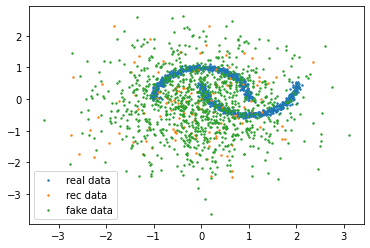

step 1000: KL: 5.974e-01, rec: 1.295e+00


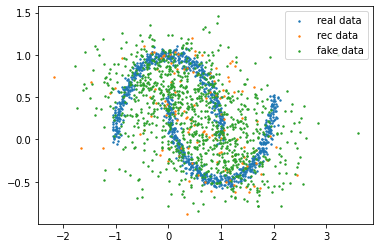

step 2000: KL: 1.254e+00, rec: 3.094e-01


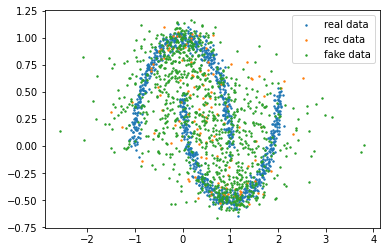

step 3000: KL: 1.361e+00, rec: 1.657e-01


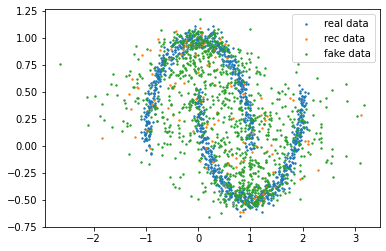

step 4000: KL: 1.423e+00, rec: 1.017e-01


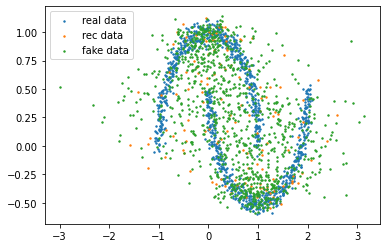

step 5000: KL: 1.473e+00, rec: 1.180e-02


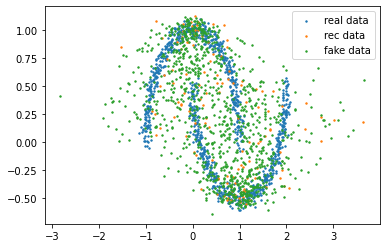

step 6000: KL: 1.509e+00, rec: -8.551e-02


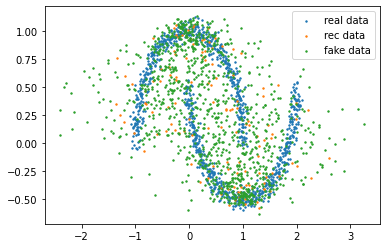

step 7000: KL: 1.488e+00, rec: -1.112e-01


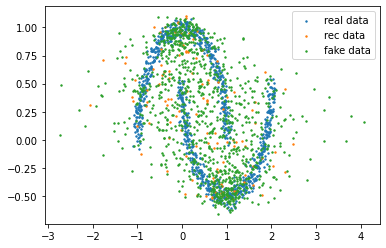

step 8000: KL: 1.519e+00, rec: -1.160e-01


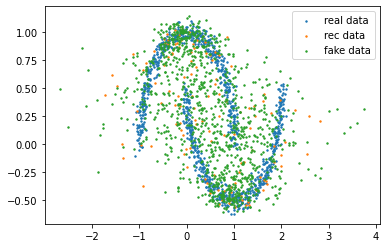

step 9000: KL: 1.558e+00, rec: -6.868e-02


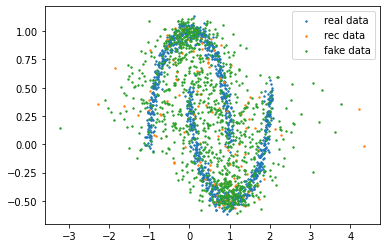

step 10000: KL: 1.523e+00, rec: 5.035e-02


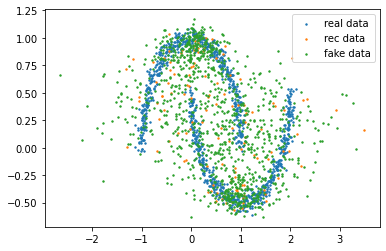

step 11000: KL: 1.559e+00, rec: 2.934e-02


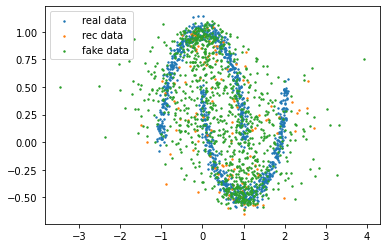

step 12000: KL: 1.549e+00, rec: -4.658e-02


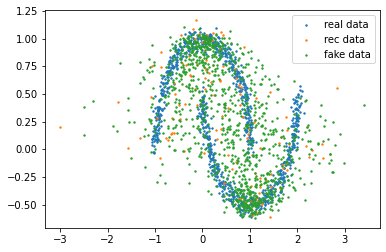

step 13000: KL: 1.620e+00, rec: -1.493e-01


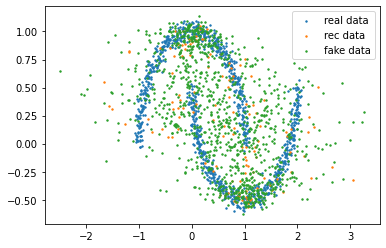

step 14000: KL: 1.616e+00, rec: -1.424e-01


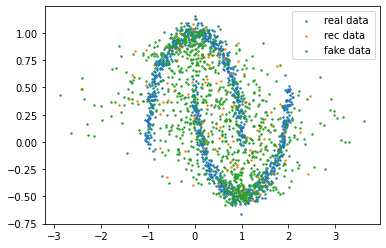

step 15000: KL: 1.614e+00, rec: -1.649e-01


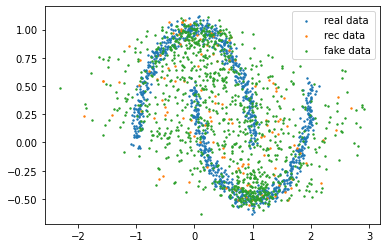

step 16000: KL: 1.610e+00, rec: -1.537e-01


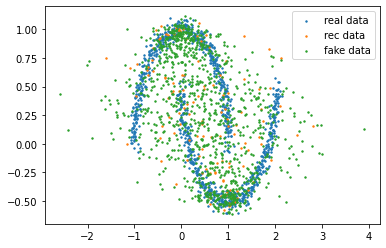

step 17000: KL: 1.668e+00, rec: -3.213e-01


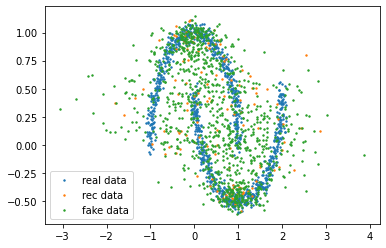

step 18000: KL: 1.541e+00, rec: 9.196e-02


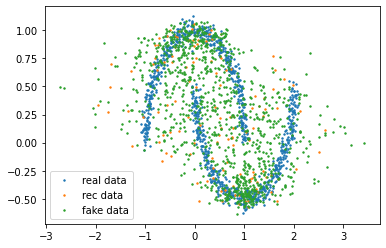

step 19000: KL: 1.638e+00, rec: -2.631e-01


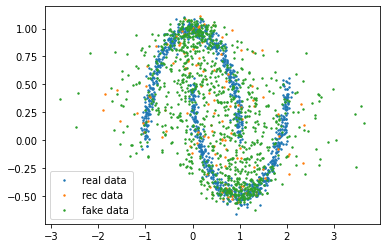

step 20000: KL: 1.635e+00, rec: -9.100e-02


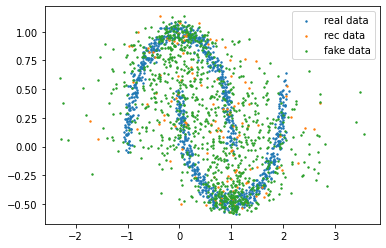

step 21000: KL: 1.686e+00, rec: -1.940e-01


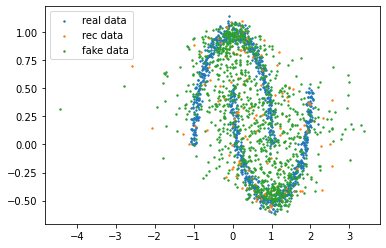

step 22000: KL: 1.662e+00, rec: -3.486e-01


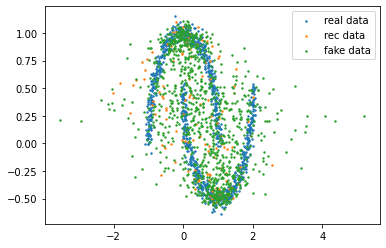

step 23000: KL: 1.689e+00, rec: -4.149e-02


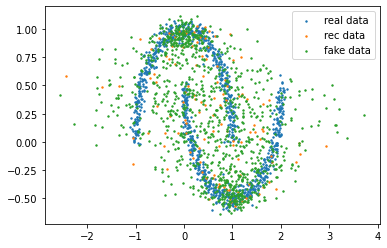

step 24000: KL: 1.719e+00, rec: -3.580e-01


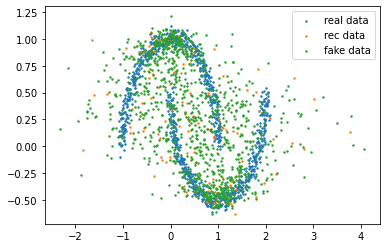

step 25000: KL: 1.599e+00, rec: -2.011e-01


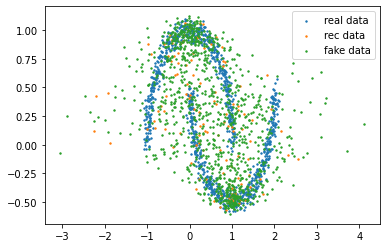

step 26000: KL: 1.647e+00, rec: -2.357e-01


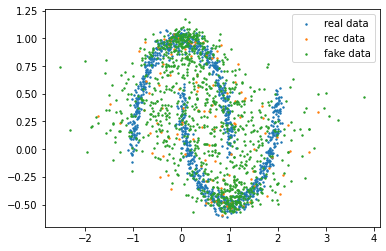

step 27000: KL: 1.728e+00, rec: -2.321e-01


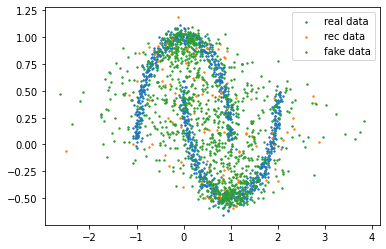

step 28000: KL: 1.699e+00, rec: -2.702e-01


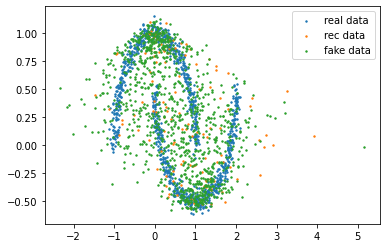

step 29000: KL: 1.655e+00, rec: -2.662e-01


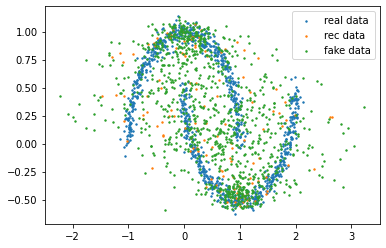

step 30000: KL: 1.676e+00, rec: -2.118e-01


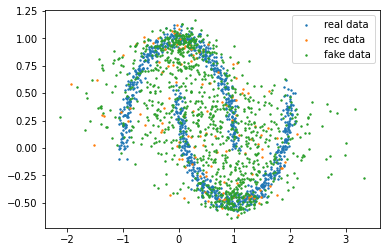

step 31000: KL: 1.715e+00, rec: -3.266e-01


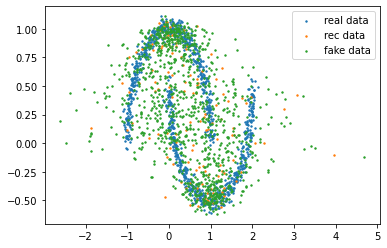

step 32000: KL: 1.661e+00, rec: -1.785e-01


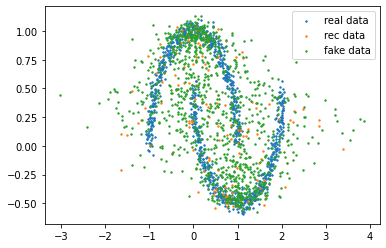

step 33000: KL: 1.714e+00, rec: -2.574e-01


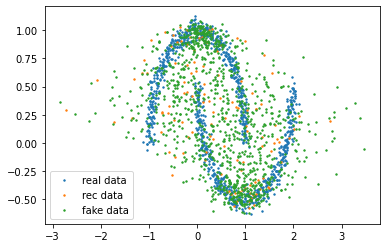

step 34000: KL: 1.721e+00, rec: -3.209e-01


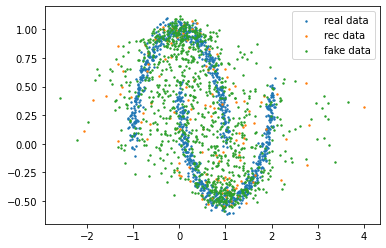

step 35000: KL: 1.702e+00, rec: -2.529e-01


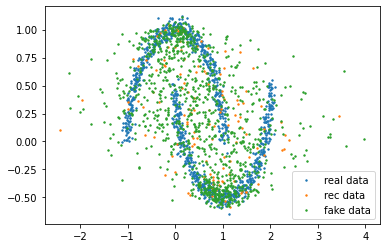

step 36000: KL: 1.780e+00, rec: -1.670e-01


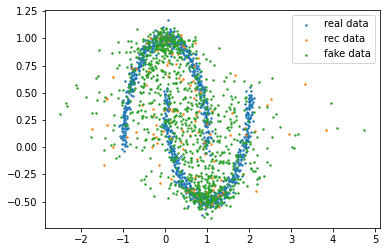

step 37000: KL: 1.749e+00, rec: -3.121e-01


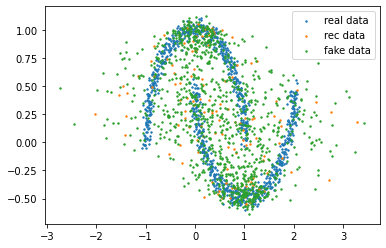

step 38000: KL: 1.762e+00, rec: -2.623e-01


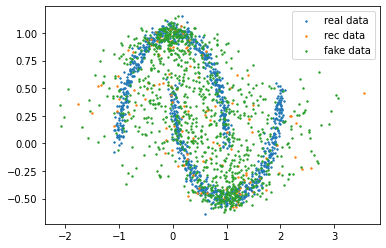

step 39000: KL: 1.711e+00, rec: -2.099e-01


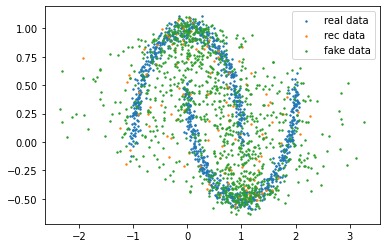

step 40000: KL: 1.776e+00, rec: -4.514e-01


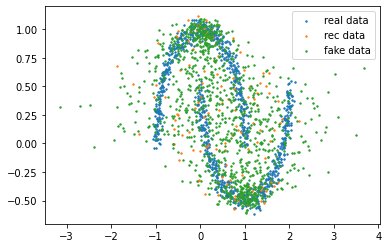

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5 * ( torch.exp(enc_logvar).sum(1) +
                     (enc_mu**2).sum(1) - 
                     enc_mu.shape[1] -
                     enc_logvar.sum(1)).mean()
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    # reparametrization trick
    eps = torch.randn(enc_mu.shape[0], LATENT_N)
    z = enc_mu + eps * torch.exp(0.5 * enc_logvar)
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5 * (dec_mu.shape[1] * np.log(2*np.pi) +
                      dec_logvar.sum(1) +
                      ((x-dec_mu)**2 / torch.exp(dec_logvar)).sum(1)).mean()

    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

step 0: KL: 1.197e-01, rec: 7.033e+03


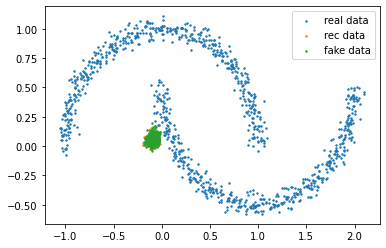

step 1000: KL: 2.442e+01, rec: 2.265e+00


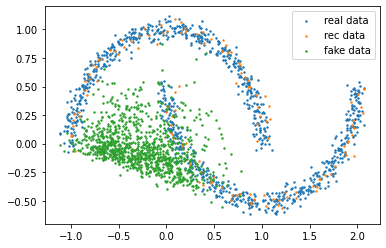

step 2000: KL: 1.915e+01, rec: -3.396e+00


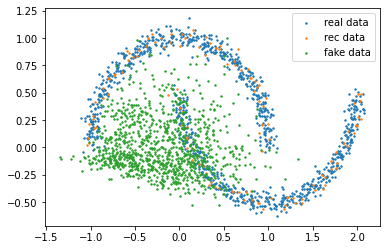

step 3000: KL: 1.605e+01, rec: -2.922e+00


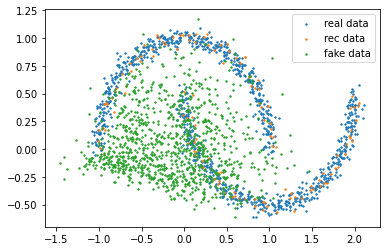

step 4000: KL: 1.478e+01, rec: -3.081e+00


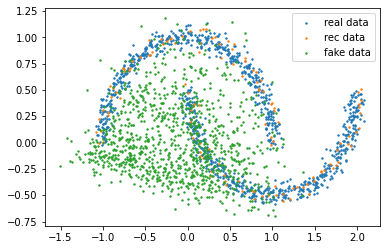

step 5000: KL: 1.327e+01, rec: -4.322e+00


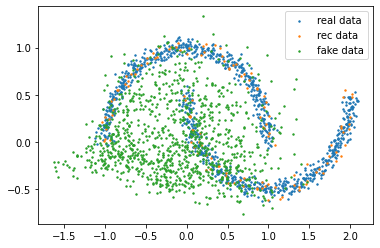

step 6000: KL: 1.263e+01, rec: -3.924e+00


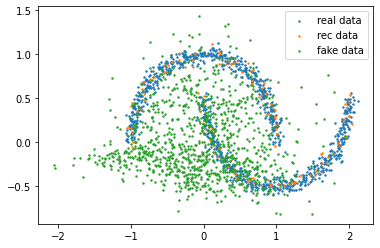

step 7000: KL: 1.212e+01, rec: -5.194e+00


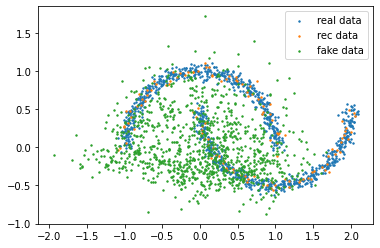

step 8000: KL: 1.169e+01, rec: 2.150e+00


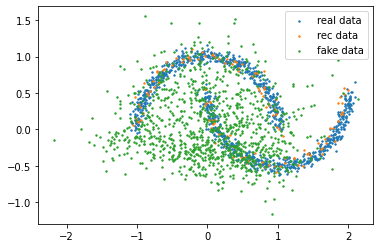

step 9000: KL: 1.125e+01, rec: -4.660e+00


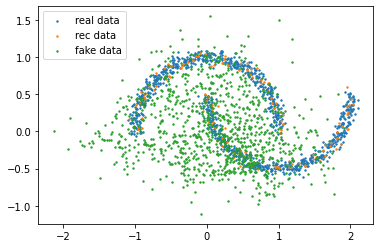

step 10000: KL: 1.082e+01, rec: 1.236e+00


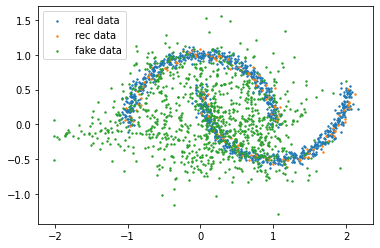

step 11000: KL: 9.936e+00, rec: -5.487e+00


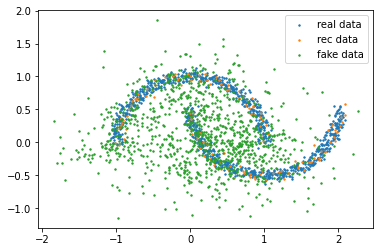

step 12000: KL: 8.803e+00, rec: -5.767e+00


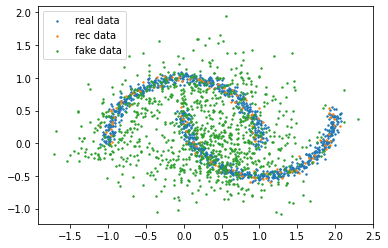

step 13000: KL: 8.320e+00, rec: -3.845e+00


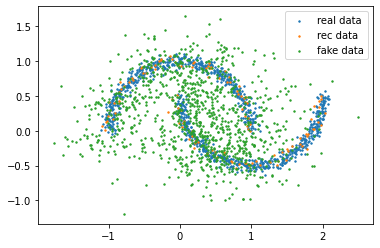

step 14000: KL: 8.225e+00, rec: -5.171e+00


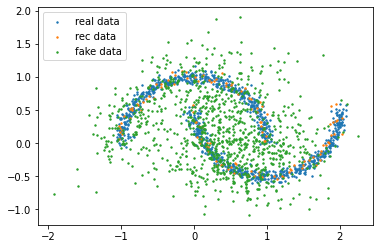

step 15000: KL: 8.195e+00, rec: -3.757e+00


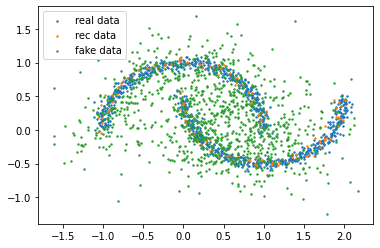

step 16000: KL: 8.185e+00, rec: -4.430e+00


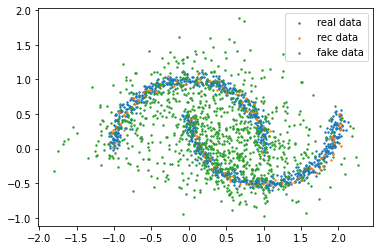

step 17000: KL: 8.172e+00, rec: -5.937e+00


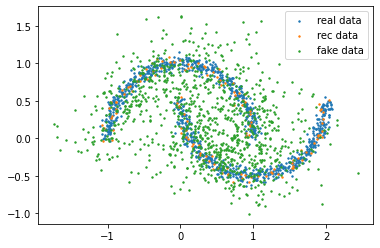

step 18000: KL: 8.127e+00, rec: -5.557e+00


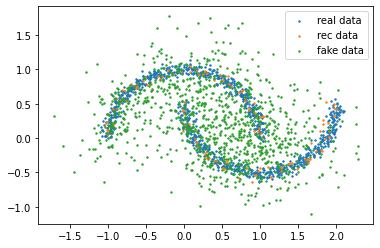

step 19000: KL: 8.105e+00, rec: -5.832e+00


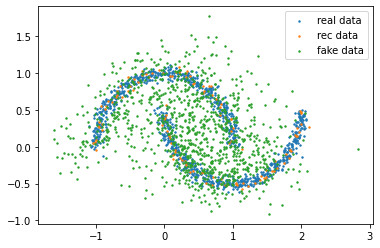

step 20000: KL: 8.100e+00, rec: -5.970e+00


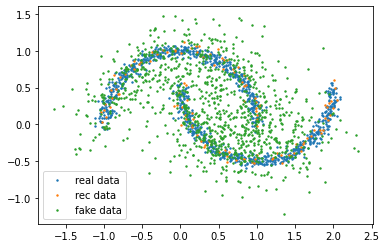

step 21000: KL: 8.083e+00, rec: -8.390e-01


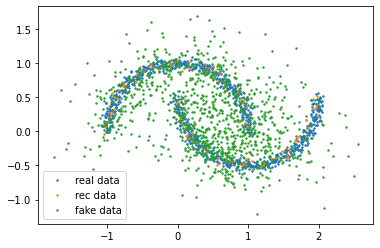

step 22000: KL: 8.126e+00, rec: -4.435e+00


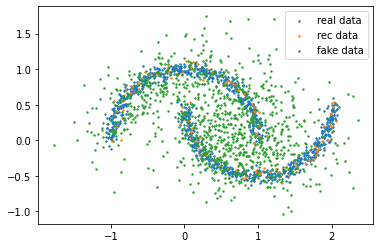

step 23000: KL: 7.980e+00, rec: -2.386e+00


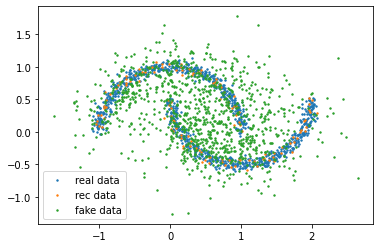

step 24000: KL: 8.025e+00, rec: -6.132e+00


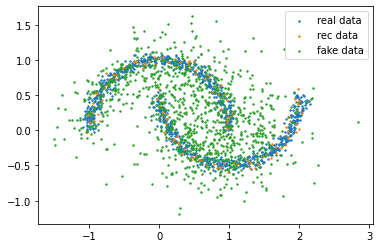

step 25000: KL: 7.980e+00, rec: -2.835e+00


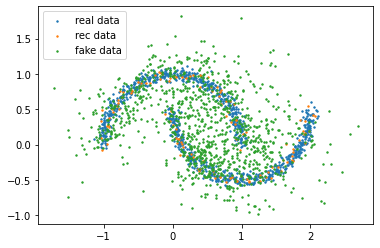

step 26000: KL: 7.998e+00, rec: -6.152e+00


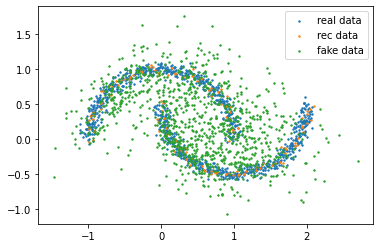

step 27000: KL: 7.979e+00, rec: -4.935e+00


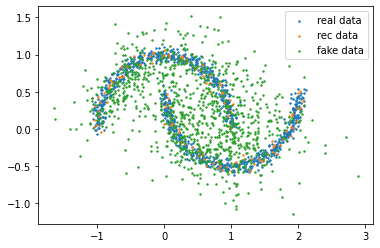

step 28000: KL: 7.928e+00, rec: -2.634e+00


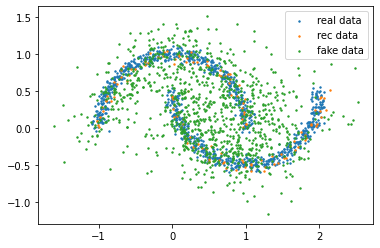

step 29000: KL: 7.956e+00, rec: -5.763e+00


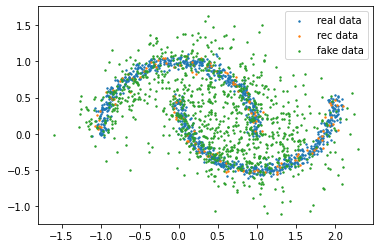

step 30000: KL: 7.978e+00, rec: -6.133e+00


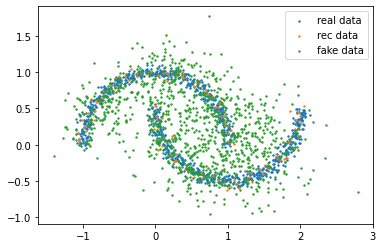

step 31000: KL: 7.837e+00, rec: -4.053e+00


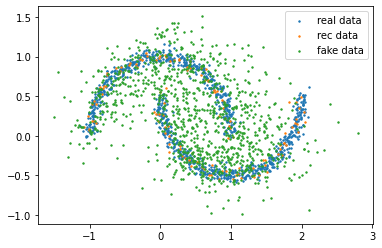

step 32000: KL: 7.867e+00, rec: -5.079e+00


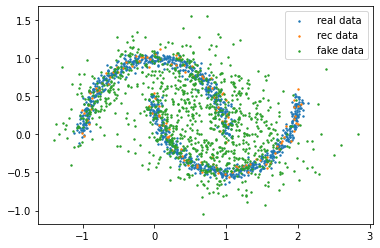

step 33000: KL: 7.919e+00, rec: -5.945e+00


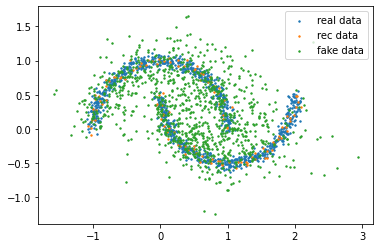

step 34000: KL: 7.871e+00, rec: -6.121e+00


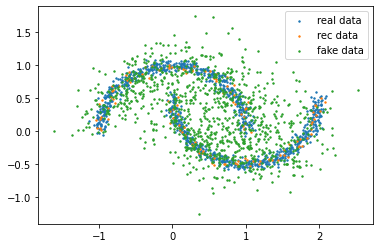

step 35000: KL: 7.912e+00, rec: -5.987e+00


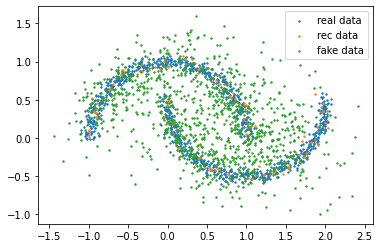

step 36000: KL: 7.870e+00, rec: -5.678e+00


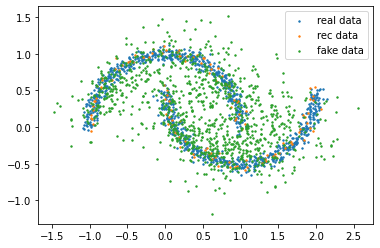

step 37000: KL: 7.899e+00, rec: -6.089e+00


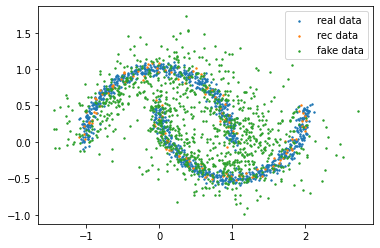

step 38000: KL: 7.801e+00, rec: -4.861e+00


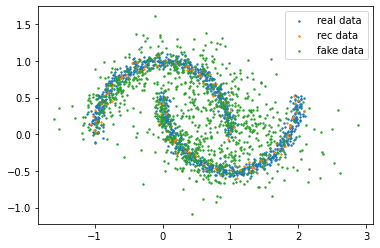

step 39000: KL: 7.828e+00, rec: -5.455e+00


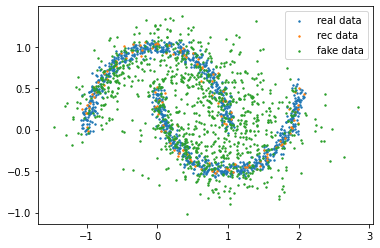

step 40000: KL: 7.855e+00, rec: -5.613e+00


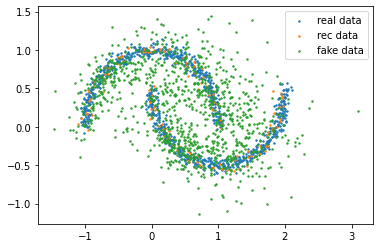

In [ ]:
# Define the discriminator
class DecoderFixedVar(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(60, 2)
        # Make the model deeper and wider
        self.fc1 = nn.Linear(LATENT_N, 15)
        self.hidden_layers = nn.ModuleList(
            [
            nn.Linear(15, 30),
            nn.Linear(30, 60)
            ]
        )

    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        z = self.fc1(z)
        z = F.relu(z)
        for layer in self.hidden_layers:
            z = layer(z)
            z = F.relu(z)
        mu = self.fc_mu(z)
        sigma = 1e-4
        logvar = np.log(sigma) * torch.ones_like(mu)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))


# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = DecoderFixedVar()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5 * ( torch.exp(enc_logvar).sum(1) +
                     (enc_mu**2).sum(1) - 
                     enc_mu.shape[1] -
                     enc_logvar.sum(1)).mean()
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    # reparametrization trick
    eps = torch.randn(enc_mu.shape[0], LATENT_N)
    z = enc_mu + eps * torch.exp(0.5 * enc_logvar)
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5 * (dec_mu.shape[1] * np.log(2*np.pi) +
                      dec_logvar.sum(1) +
                      ((x-dec_mu)**2 / torch.exp(dec_logvar)).sum(1)).mean()

    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

> Fixing the decoder variance makes the problem easier, the decoder only needs to learn the mean of the distribution. This has the effect of causing much more fast convergence of the reconstructed data to the original data. The fake data looks closer to the real data than in the previous case. On the flip side, this decoder is almost deterministic, in the sense that it produces an almost deterministic mapping from the latent space to the data space (almost no variance). If the variance is too small, it seems that the distribution generated by the encoder is not close to the Gaussian prior, and then the fake data looks really bad (all the green points concentrated in a small particular region).
>
> Note that when we fix $\sigma$, ignoring some scaling factors, the reconstruction loss is just the MSE and the KL loss is the squared norm of the mean of the latent distribution.

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

> As with the GANs, the model needs to have enough capacity to learn the data distribution. The original proposed model didn't work, after adding more layers we get better results. We consider a mirror architecture between the encoder and the decoder. Only improving one of the two didn't work either.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> It's a direct application of the change of variable rule for probabilities.
>
> In 1-D the change of variables can be derived as follows. Assume that $f$ it's a monotonic function (increasing or decreasing), then: $\mathbb{P}(X \leq x) = \mathbb{P}(f^{-1}(Z) \leq x) = \begin{cases} \mathbb{P}(Z \leq f(x)) & \text{if}\ \phantom{{-1.0}<{}} f \text{ increasing} \\
\mathbb{P}(Z \geq f(x)) & \text{if} \phantom{{-1.0}<{}} f \text{ decreasing}\\ \end{cases}$
>
>Taking derivatives at both sides
>$p_X(x) = p_Z(f(x)) |\frac{d f(x)}{dx}|$
> Extending the results to the general case we have:
>$p_X(x) = p_Z(z) |det J_f|$
>
> Applying this rule and taking log we have:
>$\log p_X(x) = \log p_Z(z) + \log det |J_f|$


Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> $KL(p_D||p_G) = \int p_D \log\frac{p_D}{p_G} = \int p_D (\log p_D - \log p_G) = \int p_D ( \log p_Z(f(X)) - \log p_G) = \int p_D(\log p_Z(f(X)) - \log p_Z (f(X)) - \log det|J_f(x)|) = -\mathbb{E}_{x \sim p_D} \log det |J_f(x)|$



A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> Let's denote $y=f(x)$, where $f$ is the proposed mapping. By definition $x_{1:d} = f^{-1}(y)_{1:d} = y_{1:d}$. Now we'll compute the other part, $x_{d+1:D} = f^{-1}(y)_{d+1:D} = \big(y_{d+1:D} - t(y_{1:d})\big) \odot exp(s(y_{1:d}))^{-1}$

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> With some abuse of notation we have $\frac{d(f(x)}{dx} = \begin{pmatrix} Id_{d \times d} & 0_{D-d \times D-d} \\ x_{d+1:D} s'(x_{1:d})) exp(s(x_{1:d}))) + t'(x_{1:d}) & \text{Diag}(\exp(s(x_{1:d}))) \end{pmatrix}$
>
> We note that the Jacobian is a triangular matrix, then its determinant is the product of the diagonal, which is what we wanted to show.

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.f_hidden = nn.Linear(input_size, hidden_size)
        self.f_output = nn.Linear(hidden_size, output_size)
        self.s_hidden = nn.Linear(input_size, hidden_size)
        self.s_output = nn.Linear(hidden_size, output_size)
        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        x_m = self.s_hidden(x_m)
        x_m = F.relu(x_m)
        x_m = self.s_output(x_m)
        x_m = F.tanh(x_m)
        return x_m
        
    def tfun(self, x_m):
        x_m = self.f_hidden(x_m)
        x_m = F.relu(x_m)
        x_m = self.f_output(x_m)
        x_m = F.tanh(x_m)
        return x_m
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        xm = y * self.mask
        return xm + (1 - self.mask) * ((y - self.tfun(xm)) / torch.exp(self.sfun(xm)))

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [0/50000 (0%)]	Loss: 0.022283
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.006587
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.023764
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.033668
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.038834
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.042042
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.043868
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.045905
====> Epoch: 1 Average train loss: -0.0306


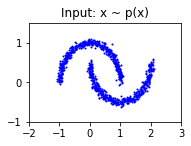

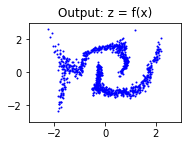

====> Test loss: -0.0473


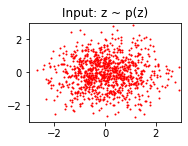

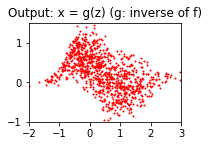

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.046192
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.047151
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.047710
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.048218
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.048985
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.049553
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.050558
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.050337
====> Epoch: 2 Average train loss: -0.0488


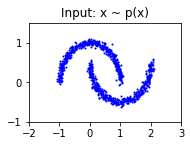

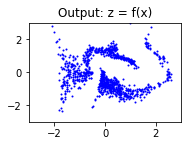

====> Test loss: -0.0520


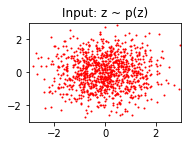

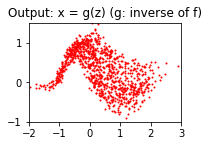

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.050871
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.051880
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.052147
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.051910
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.052728
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.052345
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.052578
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.052125
====> Epoch: 3 Average train loss: -0.0523


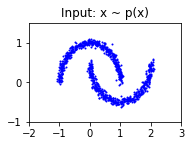

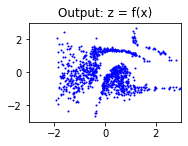

====> Test loss: -0.0549


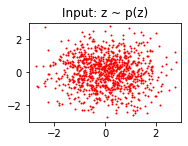

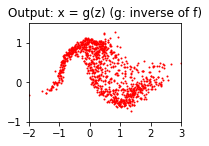

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.054215
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.054088
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.054608
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.053641
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.053574
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.055214
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.054176
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.054894
====> Epoch: 4 Average train loss: -0.0543


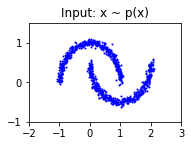

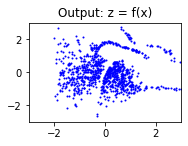

====> Test loss: -0.0565


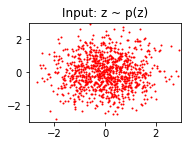

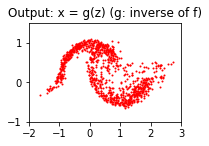

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.054846
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.054452
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.055350
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.056091
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.053764
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.055302
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.055609
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.054982
====> Epoch: 5 Average train loss: -0.0555


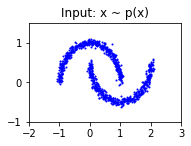

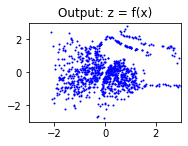

====> Test loss: -0.0573


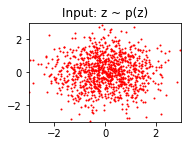

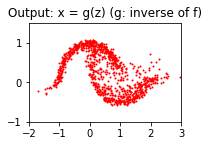

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.055267
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.055595
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.056566
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.055517
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.055340
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.056251
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.055416
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.056564
====> Epoch: 6 Average train loss: -0.0562


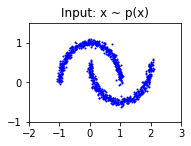

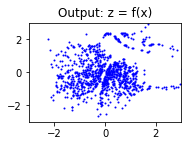

====> Test loss: -0.0579


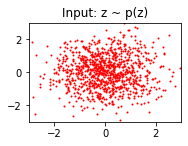

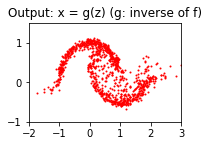

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.056817
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.056260
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.054334
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.056674
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.057166
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.057140
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.057022
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.057467
====> Epoch: 7 Average train loss: -0.0568


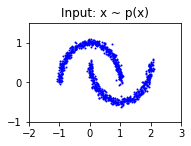

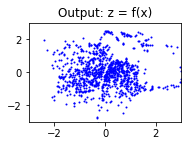

====> Test loss: -0.0584


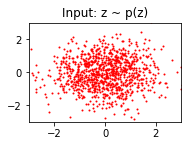

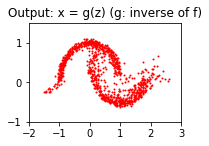

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.056477
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.056563
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.056833
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.057358
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.055391
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.057107
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.056769
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.056265
====> Epoch: 8 Average train loss: -0.0571


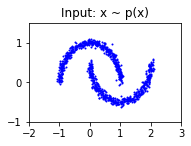

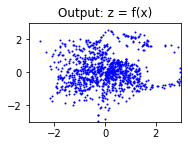

====> Test loss: -0.0589


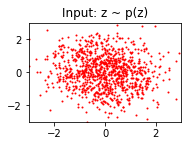

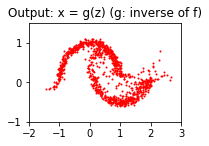

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.057527
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.056351
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.058009
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.057717
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.058153
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.057593
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.056686
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.056585
====> Epoch: 9 Average train loss: -0.0574


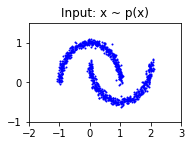

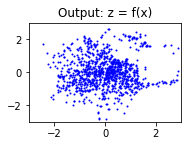

====> Test loss: -0.0593


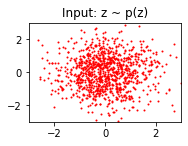

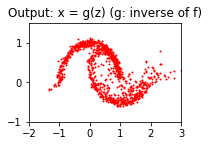

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.057542
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.058002
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.057814
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.057216
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.057250
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.056902
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.056761
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.055582
====> Epoch: 10 Average train loss: -0.0576


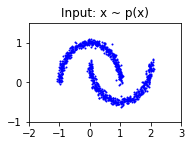

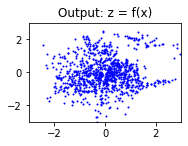

====> Test loss: -0.0594


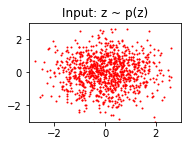

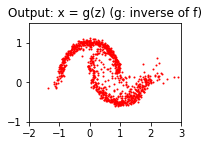

'43.96s'

<Figure size 432x288 with 0 Axes>

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> If we restrict to the formulation presented in this homework, we're assuming that the distribution of the latent variable will be a Normal distribution. In this case, if there are many clusters in the data, that means that there are many discontinuities in the space $X$. Since neural networks are typically continuous, the results of fitting a continuous mapping between a Gaussian distribution and separate clusters might be not good.

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

> * GANs are usually hard to train. You need to take care of plenty of details during the training procedure. Some of these limitations have already been solved by introducing more complex formulations like Wasserstein GANs. One advantage is the great quality of the results that are being obtained by these kind of models. Indeed, in this problem the best results were obtained with the GANs.
>
>* VAEs provide a nice mathematical framework. In this case we're not only training a generative model but we're also learning a prior distribution on the latent space. These models don't suffer from mode collapse in the same way as GANs since we're learning the latent space (if all points in the latent space would be mapped to the same mode, we'd have a high loss). However they can suffer collapse on their priors (all the training images being mapped to the same latent variables, which can make the decoder to start ignoring the prior)
>
>* Normalizing flows might not be appropiate when the data has many clusters. Its main advantages are that we get an invertible mapping, we can compute exact probabilities, and among the three seem to be the easiest to train.